In [0]:
import os
os.chdir("/content/drive/My Drive/Derin Öğrenme/AutoEncoders/VAE")
!pwd

/content/drive/My Drive/Derin Öğrenme/AutoEncoders/VAE


In [0]:
!ls

'Variational_Autoencoders_2_ (1).ipynb'   Variational_Autoencoders.ipynb
 Variational_Autoencoders_2_.ipynb


In [0]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
"""
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()"""


Using TensorFlow backend.


'\n#import tensorflow as tf\nimport tensorflow.compat.v1 as tf\ntf.disable_v2_behavior()'

In [0]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 8
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255


In [0]:
# Definition

i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)         

# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

# Use reparameterization trick to ....??
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 14, 14, 1024) 26624       encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 14, 14, 1024) 4096        conv2d_20[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 200704)       0           batch_normalization_44[0][0]     
____________________________________________________________________________________________

In [0]:

# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()



# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 200704)            602112    
_________________________________________________________________
batch_normalization_46 (Batc (None, 200704)            802816    
_________________________________________________________________
reshape_5 (Reshape)          (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 28, 28, 128)       3276928   
_________________________________________________________________
batch_normalization_50 (Batc (None, 28, 28, 128)       512       
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         1153

In [0]:

# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4044984   
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         4683521   
Total params: 8,728,505
Trainable params: 8,324,753
Non-trainable params: 403,752
_________________________________________________________________


In [0]:
# Define loss
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)


In [0]:

# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Train autoencoder
egitim_sonuc=vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)


Train on 48000 samples, validate on 12000 samples
Epoch 1/8
48000/48000 [==============================] - 54s 1ms/step - loss: 239.7525 - val_loss: 226.0010
Epoch 2/8
48000/48000 [==============================] - 53s 1ms/step - loss: 177.2961 - val_loss: 173.6053
Epoch 3/8
48000/48000 [==============================] - 53s 1ms/step - loss: 170.7913 - val_loss: 166.5255
Epoch 4/8
48000/48000 [==============================] - 53s 1ms/step - loss: 165.6015 - val_loss: 161.5730
Epoch 5/8
48000/48000 [==============================] - 53s 1ms/step - loss: 161.4959 - val_loss: 157.7843
Epoch 6/8
48000/48000 [==============================] - 53s 1ms/step - loss: 158.6678 - val_loss: 156.9370
Epoch 7/8
48000/48000 [==============================] - 53s 1ms/step - loss: 157.0511 - val_loss: 155.6792
Epoch 8/8
48000/48000 [==============================] - 53s 1ms/step - loss: 155.8542 - val_loss: 152.7558


In [0]:
vae.save_weights("vae_model_5_8epochs.h5")

In [0]:
print(egitim_sonuc.history.keys())

dict_keys(['val_loss', 'loss'])


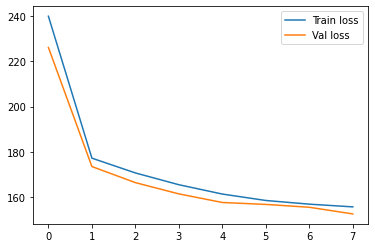

In [0]:
plt.plot(egitim_sonuc.history["loss"],label="Train loss")
plt.plot(egitim_sonuc.history["val_loss"],label="Val loss")
plt.legend()# labelların gözükmesini sağlamak
plt.show()

In [0]:
import json,codecs 
with open("vae_egitim_sonuc_5_8epochs.json","w") as f:
    json.dump(egitim_sonuc.history,f)


In [0]:
with codecs.open("vae_egitim_sonuc_5_8epochs.json","r",encoding="utf-8") as f:
    n=json.loads(f.read())

dict_keys(['val_loss', 'loss'])


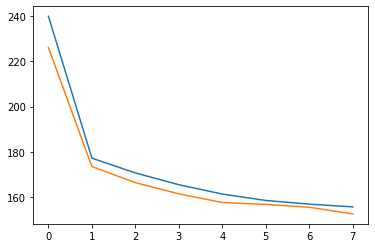

In [0]:
print(n.keys())
plt.plot(n["loss"],label="Train loss")
plt.plot(n["val_loss"],label="Val loss")

In [0]:







def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - olcu 1')
  plt.ylabel('z - olcu 2')
  plt.colorbar()
  plt.show()

In [0]:
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()


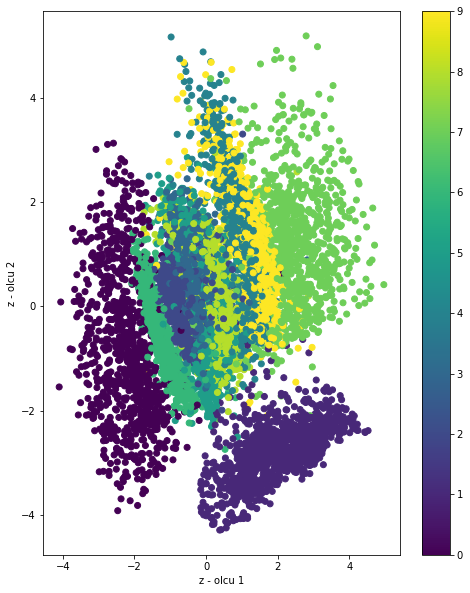

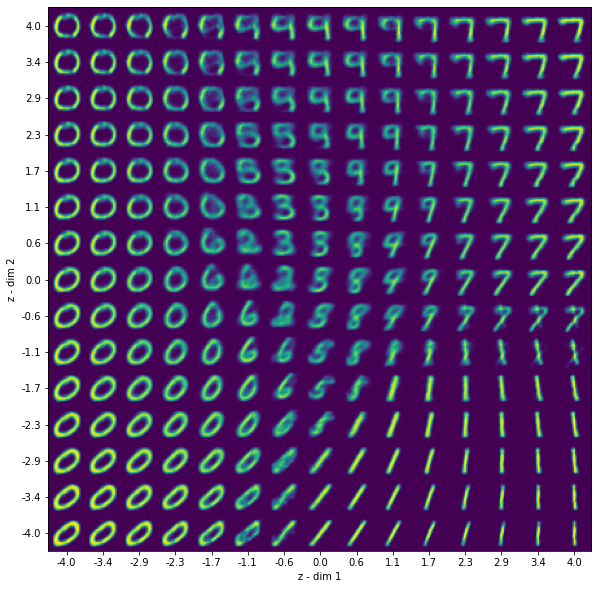

In [0]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)